# 🧪 Clustering con DBSCAN sobre STL-10 (sin embeddings)

## 🎯 Objetivo
Aplicar la técnica de **DBSCAN** sobre imágenes del dataset **STL-10**, utilizando preprocesamiento clásico sin redes neuronales profundas. El objetivo es identificar agrupaciones de imágenes similares y detectar ruido estructural.

---

In [22]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

## 🧱 Estructura del pipeline

1. **Carga de imágenes** STL-10 (train).
2. **Preprocesamiento**: aplanado y normalización.
3. **Reducción de dimensionalidad** con PCA.
4. **Aplicación de DBSCAN**.
5. **Entrenamiento de KNN** sobre puntos núcleo.
6. **Visualización en 2D** con TSNE.
7. **Muestreo de imágenes por cluster** y ruido.


## 🖼️ Preprocesamiento de imágenes

- Imágenes cargadas desde `train_images`.
- Redimensionadas a `96x96`.
- Aplanadas en vectores de tamaño `27648`.
- Normalizadas a valores entre `[0, 1]`.


In [23]:
def load_images_from_folder(folder_path, image_size=(96, 96), limit=5000):
    images = []
    files = sorted(os.listdir(folder_path))[:limit]
    for filename in files:
        try:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB').resize(image_size)
            images.append(np.array(img))
        except Exception as e:
            print(f"Error: {e}")
    return np.array(images)

# Cambiá el path a tu ruta local
train_dir = 'D:/IMPORTANTE/DataSTL-10/train_images'
X_imgs = load_images_from_folder(train_dir)
print("Imágenes cargadas:", X_imgs.shape)


Imágenes cargadas: (5000, 96, 96, 3)


In [24]:
# De (5000, 96, 96, 3) a (5000, 27648)
X_flat = X_imgs.reshape((X_imgs.shape[0], -1)).astype('float32') / 255.0
print("Shape aplanado:", X_flat.shape)


Shape aplanado: (5000, 27648)


## 📉 Reducción de dimensionalidad

Se aplicó **PCA** para reducir de `27648` a `50` dimensiones, conservando la varianza principal sin perder la estructura general de las imágenes.


In [25]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_flat)
print("Shape reducido con PCA:", X_pca.shape)


Shape reducido con PCA: (5000, 50)


In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)


## 🧠 Clustering con DBSCAN

Parámetros usados:
- `eps = 3.0`
- `min_samples = 5`

El modelo DBSCAN se ajustó sobre el espacio PCA estandarizado (`StandardScaler`), y se analizaron los siguientes resultados:


In [27]:
dbscan = DBSCAN(eps=3.0, min_samples=5)  # Ajustado para dar clusters
labels = dbscan.fit_predict(X_scaled)
print("Distribución de etiquetas DBSCAN:", Counter(labels))


Distribución de etiquetas DBSCAN: Counter({np.int64(-1): 4948, np.int64(1): 37, np.int64(0): 15})


## 🧬 Verificación de puntos núcleo en DBSCAN

Una vez ejecutado DBSCAN, es importante identificar cuántos puntos fueron considerados **núcleo** (core points). Estos puntos son los que cumplen con el criterio de `min_samples` dentro del radio `eps`.

En DBSCAN, los puntos se clasifican como:
- **Core**: tienen suficientes vecinos.
- **Border**: no tienen suficientes vecinos pero están cerca de un core.
- **Ruido**: están aislados (`label = -1`).

Usamos el atributo `core_sample_indices_` para obtener los índices de los puntos núcleo:

In [28]:
core_indices = dbscan.core_sample_indices_
print("Cantidad de puntos núcleo:", len(core_indices))


Cantidad de puntos núcleo: 19


## 🤝 Entrenamiento de KNN sobre puntos núcleo de DBSCAN

Una vez identificado el conjunto de puntos núcleo (`core_sample_indices_`), se puede utilizar esta base densa como un conjunto confiable para entrenar un clasificador **K-Nearest Neighbors (KNN)**.

El objetivo es **extender la capacidad de predicción de etiquetas** a nuevos puntos no vistos, utilizando la geometría inferida por DBSCAN.


In [29]:
if len(core_indices) > 0:
    knn = KNeighborsClassifier(n_neighbors=50)
    knn.fit(dbscan.components_, labels[core_indices])
    print("✅ KNN entrenado exitosamente")
else:
    print("❌ DBSCAN no encontró puntos núcleo. No se puede entrenar KNN.")


✅ KNN entrenado exitosamente


## 🎨 Visualización del Clustering con TSNE

Para interpretar visualmente los resultados del clustering aplicado con DBSCAN, se utiliza la técnica de reducción de dimensionalidad **t-SNE (t-Distributed Stochastic Neighbor Embedding)**. Esta técnica permite proyectar datos de alta dimensión en un espacio bidimensional, **conservando relaciones locales**, lo que la hace ideal para visualizar clusters.


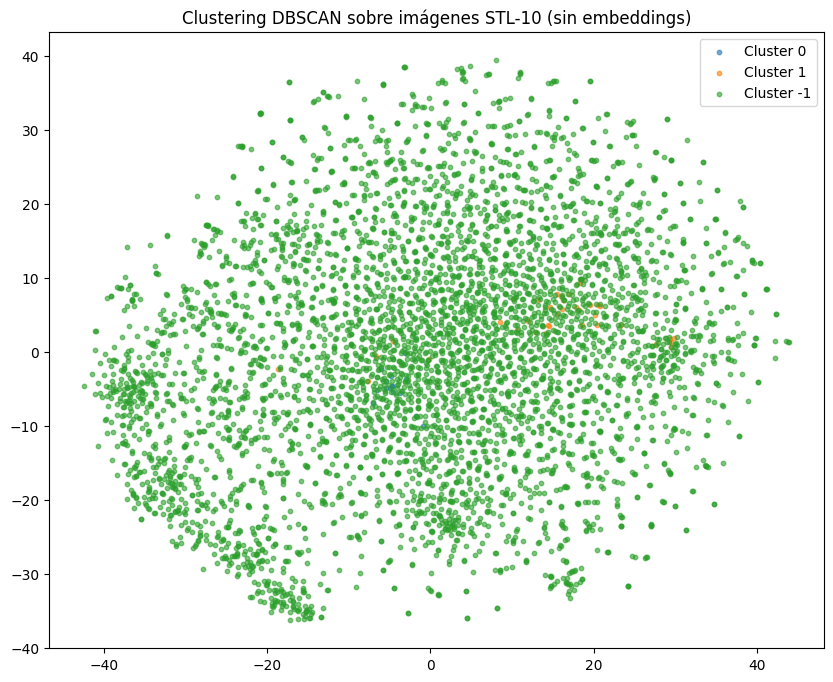

In [30]:
X_vis = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for label in set(labels):
    mask = (labels == label)
    plt.scatter(X_vis[mask, 0], X_vis[mask, 1], label=f"Cluster {label}", s=10, alpha=0.6)
plt.legend()
plt.title("Clustering DBSCAN sobre imágenes STL-10 (sin embeddings)")
plt.show()


In [31]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_flat)  # <- tus imágenes ya aplanadas y normalizadas


In [32]:
X_scaled_2d = StandardScaler().fit_transform(X_2d)

dbscan2 = DBSCAN(eps=0.5, min_samples=5)
labels2 = dbscan2.fit_predict(X_scaled_2d)

core_2d = dbscan2.core_sample_indices_
X_core_2d = dbscan2.components_
y_core_2d = labels2[core_2d]


In [33]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_core_2d, y_core_2d)


KNeighborsClassifier(n_neighbors=50)

In [34]:
X_new = np.array([
    [-0.5, 0],
    [0, 0.5],
    [1, -0.1],
    [2, -1]
])


## 🧭 Visualización de fronteras de decisión con KNN

Después de entrenar un modelo **KNN sobre los puntos núcleo de DBSCAN**, se implementa una visualización de las **fronteras de decisión** para interpretar cómo este modelo propaga las etiquetas a nuevas regiones del espacio.

La función `plot_decision_boundaries` genera un mapa de decisión donde cada zona está coloreada según la clase asignada por KNN.


In [37]:
def plot_decision_boundaries(clf, X, h=0.2, padding=0.5):
    x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
    y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)


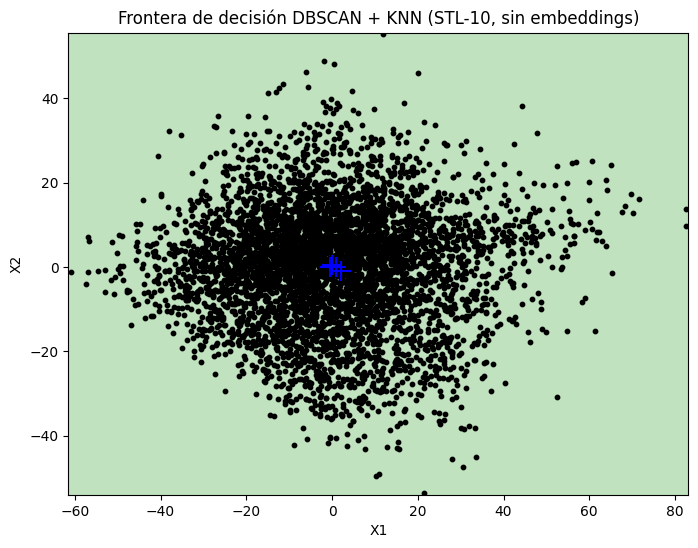

In [38]:
plt.figure(figsize=(8, 6))
plot_decision_boundaries(knn, X_2d, h=0.2)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c='black', s=10)
plt.scatter(X_new[:, 0], X_new[:, 1], c='blue', s=200, marker="+", zorder=10)

plt.title("Frontera de decisión DBSCAN + KNN (STL-10, sin embeddings)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


In [39]:
print("Imágenes:", len(X_imgs))
print("Etiquetas:", len(labels))


Imágenes: 5000
Etiquetas: 5000


## 🖼️ Visualización de imágenes por cluster

Para validar la calidad del clustering realizado con DBSCAN, se implementa una función que permite **visualizar imágenes reales** asociadas a un `cluster_id` específico (incluyendo el ruido, `cluster_id = -1`).

Esto es crucial para **verificar si las agrupaciones tienen sentido semántico o visual**.

In [40]:
def mostrar_imagenes_por_cluster(X_imgs, labels, cluster_id, filas=1, columnas=5):
    if len(X_imgs) != len(labels):
        print("⚠️ La cantidad de imágenes y etiquetas no coincide.")
        return

    idx = np.where(labels == cluster_id)[0]
    if len(idx) == 0:
        print(f"⚠️ No hay imágenes en el cluster {cluster_id}")
        return

    seleccionadas = np.random.choice(idx, min(len(idx), filas * columnas), replace=False)
    
    plt.figure(figsize=(15, 3))
    for i, img_idx in enumerate(seleccionadas):
        plt.subplot(filas, columnas, i + 1)
        img = X_imgs[img_idx]
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"ID {img_idx}")
    
    plt.suptitle(f"Imágenes del Cluster {cluster_id}", fontsize=16)
    plt.show()


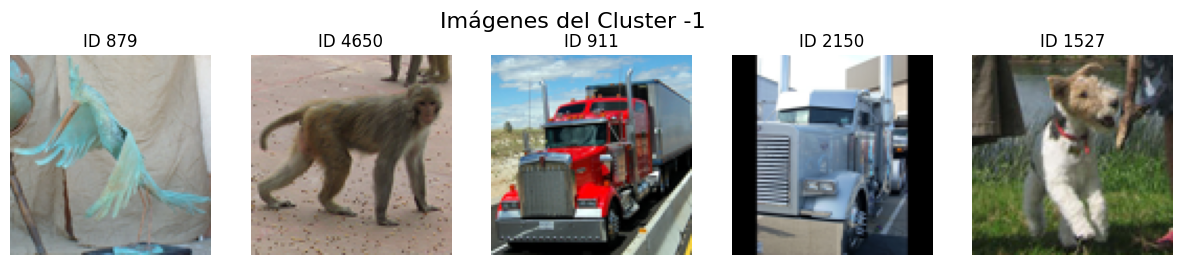

In [41]:
mostrar_imagenes_por_cluster(X_imgs, labels, cluster_id=-1)

In [42]:
from collections import Counter
print("Clusters disponibles:", Counter(labels))

Clusters disponibles: Counter({np.int64(-1): 4948, np.int64(1): 37, np.int64(0): 15})


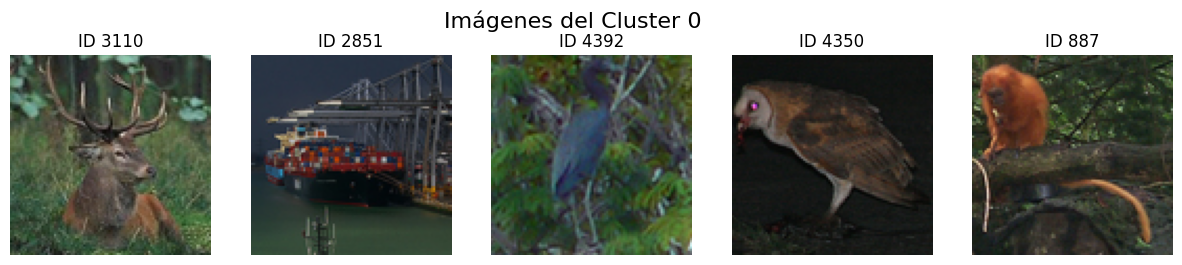

In [43]:
mostrar_imagenes_por_cluster(X_imgs, labels, cluster_id=0)  # o 1, 2, etc.


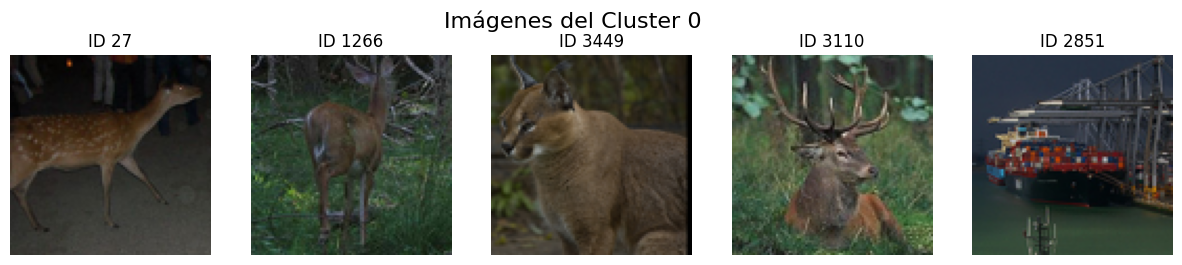

In [44]:
mostrar_imagenes_por_cluster(X_imgs, labels, cluster_id=0)  # o 1, 2, etc.
